In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BULDING DATASET

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
def combined_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    accelerator.print(current_train_size, checkpoints[-1] - target_samples)
    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get Monte Carlo samples
        mc_indices = get_monte_carlo_samples(model, dataloader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from mc")
        
        # Get KMeans samples
        kmeans_indices = get_kmeans_samples(model, dataloader, device, target_samples)
        kmeans_indices = [remaining_indices[i] for i in kmeans_indices]
        accelerator.print(f"Got {len(kmeans_indices)} samples from kmeans")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(mc_indices).union(set(kmeans_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_kmeans_samples(model, dataloader, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    
    # Cluster the data based on its embeddings
    kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    kmeans.fit(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    
    for cluster_id in range(n_clusters):
        # Cluster center and indices of samples in the current cluster
        cluster_center = kmeans.cluster_centers_[cluster_id]
        cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
        
        if cluster_indices.size == 0:
            # Skip clusters with no members
            continue
        
        # Calculate distances of each point in the cluster from the cluster center
        cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
        
        # Determine the local threshold (90th percentile of distances to cluster center)
        local_threshold = np.percentile(cluster_distances, 90)
        
        # Get indices of points with distances greater than or equal to threshold
        below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
        collected_indices.update(below_threshold_indices)
    
    # Randomly shuffle and select required number of samples
    collected_indices = np.array(list(collected_indices))
    
    # Return only the requested number of samples
    return collected_indices[:n_samples]

def get_monte_carlo_samples(model, dataloader, device, n_samples):
    model.train()

    confidences = []
    # Calculate uncertainties
    for data in dataloader:
        batch_probs = []
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)

        for _ in range(3):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(confidences, 90)
    items_greater_than_average = uncertainties[confidences >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = 'netifier-lc-kmeans'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5729, Accuracy: 0.803, F1 Micro: 0.1428, F1 Macro: 0.1109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4536, Accuracy: 0.8375, F1 Micro: 0.426, F1 Macro: 0.3115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3792, Accuracy: 0.8686, F1 Micro: 0.6319, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3084, Accuracy: 0.8767, F1 Micro: 0.7057, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2417, Accuracy: 0.8825, F1 Micro: 0.7094, F1 Macro: 0.7012
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1911, Accuracy: 0.8872, F1 Micro: 0.7225, F1 Macro: 0.7152
Epoch 7/10, Train Loss: 0.1479, Accuracy: 0.8844, F1 Micro: 0.7156, F1 Macro: 0.7083
Epoch 8/10, Train Loss: 0.1175, Accuracy: 0.885, F1 Micro: 0.7167, F1 Macro: 0.7109
Epoch 9/10, Train Loss: 0.0952, Accuracy: 0.8866, F1 Micro: 0.7212, F1 Macro: 0.7205
Epoch 10/10, Train Loss: 0.0762, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5446, Accuracy: 0.8277, F1 Micro: 0.3431, F1 Macro: 0.2481
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4078, Accuracy: 0.8708, F1 Micro: 0.6869, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3179, Accuracy: 0.8823, F1 Micro: 0.7004, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.242, Accuracy: 0.8873, F1 Micro: 0.7209, F1 Macro: 0.712
Epoch 5/10, Train Loss: 0.1974, Accuracy: 0.8898, F1 Micro: 0.71, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1627, Accuracy: 0.8914, F1 Micro: 0.7295, F1 Macro: 0.724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1159, Accuracy: 0.8883, F1 Micro: 0.737, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.8913, F1 Micro: 0.7397, F1 Macro: 0.7377
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.8914, F1 Micro: 0.7346, F1 Macro: 0.7274
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5185, Accuracy: 0.8487, F1 Micro: 0.5203, F1 Macro: 0.423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.8763, F1 Micro: 0.6738, F1 Macro: 0.6676
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2892, Accuracy: 0.8883, F1 Micro: 0.7177, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2373, Accuracy: 0.8906, F1 Micro: 0.7233, F1 Macro: 0.709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1808, Accuracy: 0.8958, F1 Micro: 0.7593, F1 Macro: 0.7538
Epoch 6/10, Train Loss: 0.1415, Accuracy: 0.8919, F1 Micro: 0.752, F1 Macro: 0.7532
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.8948, F1 Micro: 0.7512, F1 Macro: 0.7472
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.8956, F1 Micro: 0.7564, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.8953, F1 Micro: 0.7513, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0524, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4978, Accuracy: 0.8577, F1 Micro: 0.5643, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3607, Accuracy: 0.8823, F1 Micro: 0.7185, F1 Macro: 0.7035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2671, Accuracy: 0.8961, F1 Micro: 0.7465, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2262, Accuracy: 0.8998, F1 Micro: 0.7731, F1 Macro: 0.7666
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.8981, F1 Micro: 0.7629, F1 Macro: 0.7577
Epoch 6/10, Train Loss: 0.1348, Accuracy: 0.8991, F1 Micro: 0.7547, F1 Macro: 0.7458
Epoch 7/10, Train Loss: 0.1007, Accuracy: 0.8961, F1 Micro: 0.7644, F1 Macro: 0.76
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9003, F1 Micro: 0.7626, F1 Macro: 0.7521
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.8986, F1 Micro: 0.7548, F1 Macro: 0.7487
Epoch 10/10, Train Loss: 0.0496, Accuracy: 0.898, F1 Micro: 0.7559, F1 Macro: 0.7513

 Iteration 2394: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4912, Accuracy: 0.863, F1 Micro: 0.5888, F1 Macro: 0.5092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3434, Accuracy: 0.8848, F1 Micro: 0.7279, F1 Macro: 0.7207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.268, Accuracy: 0.893, F1 Micro: 0.7635, F1 Macro: 0.7676
Epoch 4/10, Train Loss: 0.2213, Accuracy: 0.8997, F1 Micro: 0.7542, F1 Macro: 0.7462
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.8947, F1 Micro: 0.7208, F1 Macro: 0.7078
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.8981, F1 Micro: 0.7504, F1 Macro: 0.7441
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9003, F1 Micro: 0.7634, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9034, F1 Micro: 0.7736, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.902, F1 Micro: 0.7753, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0476, Accuracy: 0.9023, F1 Micro: 0.7665, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4742, Accuracy: 0.8506, F1 Micro: 0.5041, F1 Macro: 0.4264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3353, Accuracy: 0.8888, F1 Micro: 0.7493, F1 Macro: 0.7399
Epoch 3/10, Train Loss: 0.2686, Accuracy: 0.8955, F1 Micro: 0.7398, F1 Macro: 0.7173
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.9005, F1 Micro: 0.7555, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1728, Accuracy: 0.902, F1 Micro: 0.7731, F1 Macro: 0.7687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9048, F1 Micro: 0.7788, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9009, F1 Micro: 0.7522, F1 Macro: 0.7468
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.9023, F1 Micro: 0.7713, F1 Macro: 0.7677
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9003, F1 Micro: 0.7715, F1 Macro: 0.7697
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.905, F1 Micro: 0.7778, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4733, Accuracy: 0.873, F1 Micro: 0.6614, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3272, Accuracy: 0.8931, F1 Micro: 0.7467, F1 Macro: 0.732
Epoch 3/10, Train Loss: 0.2495, Accuracy: 0.8975, F1 Micro: 0.7427, F1 Macro: 0.7338
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2018, Accuracy: 0.9044, F1 Micro: 0.7783, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9019, F1 Micro: 0.7776, F1 Macro: 0.7734
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9027, F1 Micro: 0.7646, F1 Macro: 0.7608
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9034, F1 Micro: 0.7844, F1 Macro: 0.7832
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9017, F1 Micro: 0.7723, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.8992, F1 Micro: 0.7807, F1 Macro: 0.7826
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9005, F1 Micro: 0.7744, F1 Macro: 0.773

 Iteration 3432: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4586, Accuracy: 0.87, F1 Micro: 0.6183, F1 Macro: 0.5845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3128, Accuracy: 0.895, F1 Micro: 0.7579, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2624, Accuracy: 0.9008, F1 Micro: 0.767, F1 Macro: 0.7663
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9003, F1 Micro: 0.7623, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1723, Accuracy: 0.9061, F1 Micro: 0.7799, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9036, F1 Micro: 0.7788, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9033, F1 Micro: 0.7755, F1 Macro: 0.7755
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.905, F1 Micro: 0.7799, F1 Macro: 0.7769
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9022, F1 Micro: 0.7725, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9022, F1 Micro: 0.7774, F1 Macro: 0.7751

 Iteration 3711: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.8769, F1 Micro: 0.696, F1 Macro: 0.6914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3036, Accuracy: 0.8964, F1 Micro: 0.7505, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2544, Accuracy: 0.9003, F1 Micro: 0.7797, F1 Macro: 0.7762
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.898, F1 Micro: 0.7612, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9042, F1 Micro: 0.7797, F1 Macro: 0.7725
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9044, F1 Micro: 0.7723, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9041, F1 Micro: 0.781, F1 Macro: 0.7778
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9014, F1 Micro: 0.7794, F1 Macro: 0.7789
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9006, F1 Micro: 0.7602, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0374, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4476, Accuracy: 0.8761, F1 Micro: 0.6796, F1 Macro: 0.6709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3049, Accuracy: 0.8936, F1 Micro: 0.7528, F1 Macro: 0.746
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.9025, F1 Micro: 0.7482, F1 Macro: 0.7343
Epoch 4/10, Train Loss: 0.2108, Accuracy: 0.9011, F1 Micro: 0.7503, F1 Macro: 0.7378
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.8988, F1 Micro: 0.7475, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9017, F1 Micro: 0.7824, F1 Macro: 0.7807
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9048, F1 Micro: 0.7685, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9033, F1 Micro: 0.7771, F1 Macro: 0.7761
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9027, F1 Micro: 0.7776, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9084, F1 Micro: 0.7878, F1 Macro: 0.7884

 Iteration 4120: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4323, Accuracy: 0.8786, F1 Micro: 0.6822, F1 Macro: 0.6646
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.8988, F1 Micro: 0.7652, F1 Macro: 0.7517
Epoch 3/10, Train Loss: 0.2416, Accuracy: 0.9019, F1 Micro: 0.7618, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1981, Accuracy: 0.9083, F1 Micro: 0.7855, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.1545, Accuracy: 0.9056, F1 Micro: 0.7804, F1 Macro: 0.7792
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9047, F1 Micro: 0.7579, F1 Macro: 0.7495
Epoch 7/10, Train Loss: 0.0956, Accuracy: 0.9038, F1 Micro: 0.7629, F1 Macro: 0.7561
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9056, F1 Micro: 0.7789, F1 Macro: 0.7724
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9034, F1 Micro: 0.7723, F1 Macro: 0.7682
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9023, F1 Micro: 0.7812, F1 Macro: 0.7783

 Iteration 4330: Accuracy: 0.9083, F1 Micro: 0.785

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4317, Accuracy: 0.8766, F1 Micro: 0.6589, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.9016, F1 Micro: 0.7626, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2378, Accuracy: 0.8948, F1 Micro: 0.7733, F1 Macro: 0.7754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.905, F1 Micro: 0.7773, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.8984, F1 Micro: 0.7816, F1 Macro: 0.7819
Epoch 6/10, Train Loss: 0.1163, Accuracy: 0.9041, F1 Micro: 0.7618, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9038, F1 Micro: 0.7828, F1 Macro: 0.7774
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9023, F1 Micro: 0.7786, F1 Macro: 0.7735
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9041, F1 Micro: 0.7774, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.0423, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.8823, F1 Micro: 0.7134, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.8947, F1 Micro: 0.7249, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.9039, F1 Micro: 0.7787, F1 Macro: 0.774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1964, Accuracy: 0.9027, F1 Micro: 0.7886, F1 Macro: 0.7881
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9042, F1 Micro: 0.7818, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.9025, F1 Micro: 0.7635, F1 Macro: 0.7594
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9044, F1 Micro: 0.7822, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9027, F1 Micro: 0.765, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9052, F1 Micro: 0.783, F1 Macro: 0.7812
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9028, F1 Micro: 0.7764, F1 Macro: 0.773

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.882, F1 Micro: 0.6991, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8973, F1 Micro: 0.7658, F1 Macro: 0.7624
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9013, F1 Micro: 0.7452, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9027, F1 Micro: 0.7806, F1 Macro: 0.7766
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9052, F1 Micro: 0.779, F1 Macro: 0.7715
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9039, F1 Micro: 0.774, F1 Macro: 0.7684
Epoch 7/10, Train Loss: 0.0804, Accuracy: 0.9033, F1 Micro: 0.7695, F1 Macro: 0.7649
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.8991, F1 Micro: 0.7597, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9011, F1 Micro: 0.774, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.9023, F1 Micro: 0.7748, F1 Macro: 0.7729

 Iteration 4863: Accuracy: 0.9027, F1 Micro: 0.7806, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4131, Accuracy: 0.8823, F1 Micro: 0.7406, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2767, Accuracy: 0.8991, F1 Micro: 0.7597, F1 Macro: 0.7474
Epoch 3/10, Train Loss: 0.2237, Accuracy: 0.9047, F1 Micro: 0.7595, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9038, F1 Micro: 0.767, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.905, F1 Micro: 0.7859, F1 Macro: 0.7809
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9083, F1 Micro: 0.783, F1 Macro: 0.7796
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9075, F1 Micro: 0.7742, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9044, F1 Micro: 0.7738, F1 Macro: 0.7659
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9008, F1 Micro: 0.7713, F1 Macro: 0.7675
Epoch 10/10, Train Loss: 0.0386, Accuracy: 0.905, F1 Micro: 0.7688, F1 Macro: 0.7606

 Iteration 5063: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4057, Accuracy: 0.885, F1 Micro: 0.7114, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.8998, F1 Micro: 0.7489, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9045, F1 Micro: 0.7741, F1 Macro: 0.7661
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9013, F1 Micro: 0.7713, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9038, F1 Micro: 0.7747, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9059, F1 Micro: 0.7861, F1 Macro: 0.782
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9023, F1 Micro: 0.77, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.903, F1 Micro: 0.7731, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9033, F1 Micro: 0.7862, F1 Macro: 0.7856
Epoch 10/10, Train Loss: 0.0375, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8858, F1 Micro: 0.7159, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.8934, F1 Micro: 0.717, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9055, F1 Micro: 0.7901, F1 Macro: 0.7855
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9055, F1 Micro: 0.7801, F1 Macro: 0.777
Epoch 5/10, Train Loss: 0.1402, Accuracy: 0.9059, F1 Micro: 0.7648, F1 Macro: 0.7501
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.9034, F1 Micro: 0.7818, F1 Macro: 0.7762
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9052, F1 Micro: 0.7833, F1 Macro: 0.7819
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9038, F1 Micro: 0.7703, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9069, F1 Micro: 0.7839, F1 Macro: 0.7777
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9069, F1 Micro: 0.7789, F1 Macro: 0.7755

 Iteration 5441: Accuracy: 0.9055, F1 Micro: 0.7901, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8884, F1 Micro: 0.7298, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.9002, F1 Micro: 0.7749, F1 Macro: 0.7709
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.903, F1 Micro: 0.7794, F1 Macro: 0.7776
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.9033, F1 Micro: 0.7793, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.9017, F1 Micro: 0.787, F1 Macro: 0.7887
Epoch 6/10, Train Loss: 0.1013, Accuracy: 0.9044, F1 Micro: 0.7791, F1 Macro: 0.7708
Epoch 7/10, Train Loss: 0.0705, Accuracy: 0.8994, F1 Micro: 0.7393, F1 Macro: 0.7313
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9016, F1 Micro: 0.7665, F1 Macro: 0.763
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9089, F1 Micro: 0.7842, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9047, F1 Micro: 0.7806, F1 Macro: 0.7801

 Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8897, F1 Micro: 0.7535, F1 Macro: 0.748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.9028, F1 Micro: 0.7713, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2148, Accuracy: 0.9062, F1 Micro: 0.7856, F1 Macro: 0.7808
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9055, F1 Micro: 0.769, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9069, F1 Micro: 0.7814, F1 Macro: 0.7796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.094, Accuracy: 0.9052, F1 Micro: 0.7856, F1 Macro: 0.7821
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9077, F1 Micro: 0.7719, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9011, F1 Micro: 0.7702, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.902, F1 Micro: 0.7801, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9025, F1 Micro: 0.7776, F1 Macro: 0.7712

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3681, Accuracy: 0.8863, F1 Micro: 0.7211, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9014, F1 Micro: 0.777, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9045, F1 Micro: 0.7828, F1 Macro: 0.7764
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9048, F1 Micro: 0.7675, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9083, F1 Micro: 0.7806, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9045, F1 Micro: 0.7795, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9016, F1 Micro: 0.7783, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9039, F1 Micro: 0.7886, F1 Macro: 0.7862
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.907, F1 Micro: 0.7721, F1 Macro: 0.7676
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9019, F1 Micro: 0.7713, F1 Macro: 0.7663

 Iteration 6041: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3654, Accuracy: 0.8906, F1 Micro: 0.7417, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.8992, F1 Micro: 0.7717, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.903, F1 Micro: 0.7816, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.9073, F1 Micro: 0.7852, F1 Macro: 0.779
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9061, F1 Micro: 0.775, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9013, F1 Micro: 0.7741, F1 Macro: 0.7697
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9052, F1 Micro: 0.7794, F1 Macro: 0.7752
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9003, F1 Micro: 0.7823, F1 Macro: 0.7828
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9038, F1 Micro: 0.7789, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9048, F1 Micro: 0.7805, F1 Macro: 0.7765

 Iteration 6218: Accu

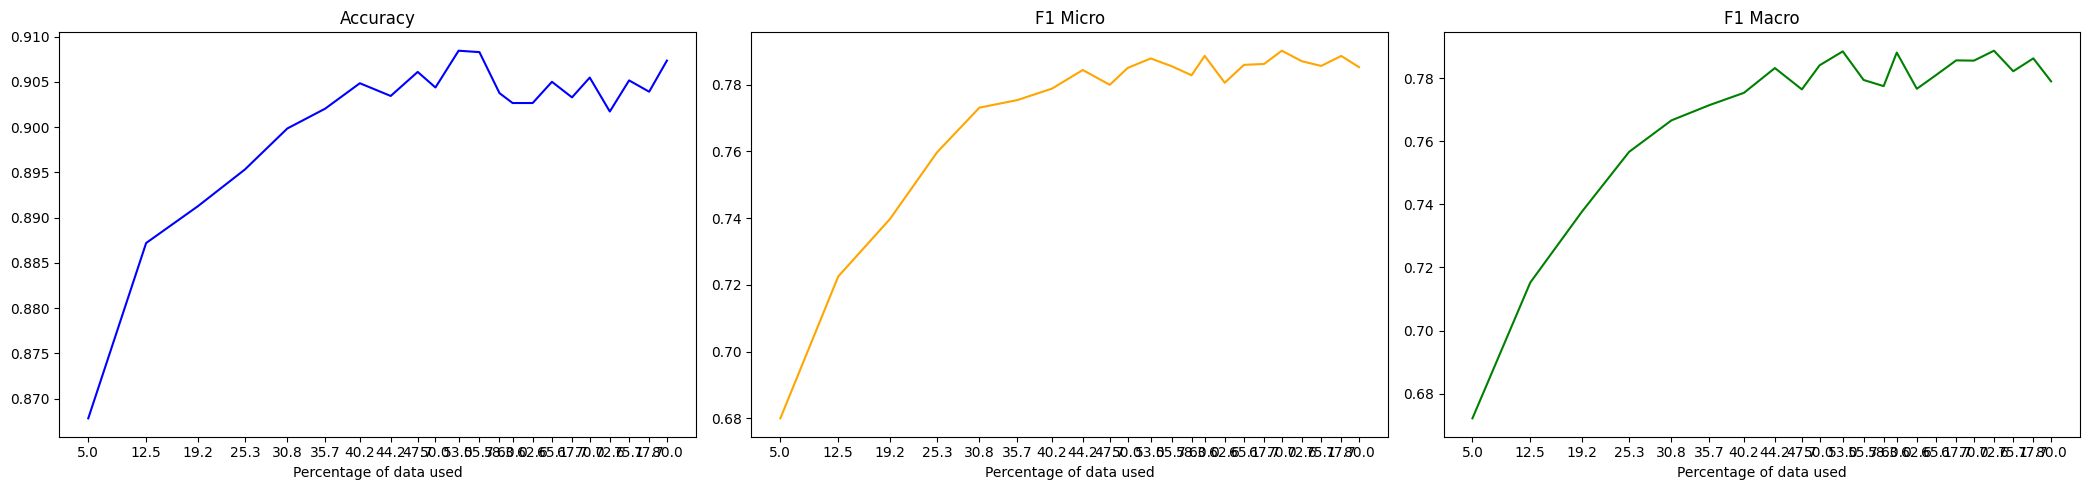

In [18]:
active_learning(seeds[0], 0)